In [ ]:
import os

import numpy as np
import pickle

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import cdist

from utils import STIM_INFO_PATH, COCO_IMAGES_DIR, SUBJECTS, FMRI_DATA_DIR, FMRI_RAW_BIDS_DATA_DIR, RESULTS_DIR
from eval import get_distance_matrix
from data import get_fmri_data_paths, get_latent_features, LatentFeatsConfig, standardize_latents, IMAGE, CAPTION, SPLIT_TRAIN, SPLIT_TEST, SPLIT_IMAGERY, get_fmri_data, get_stim_info, IMAGERY
from analyses.decoding.ridge_regression_decoding import get_run_str, RIDGE_DECODER_OUT_DIR, RESULTS_FILE
from feature_extraction.feat_extraction_utils import CoCoDataset
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import trange
import nibabel
from PIL import Image
import pandas as pd
from IPython.display import display, HTML
from io import BytesIO
import base64
from pdf2image import convert_from_path



In [ ]:
coco_ds = CoCoDataset(COCO_IMAGES_DIR, STIM_INFO_PATH)

In [ ]:
def resize_img(image, length=100):
    if image.size[0] < image.size[1]:
        resized_image = image.resize((length, int(image.size[1] * (length / image.size[0]))))
        required_loss = (resized_image.size[1] - length)
        resized_image = resized_image.crop(box=(0, required_loss / 2, length, resized_image.size[1] - required_loss / 2))
    else:
        resized_image = image.resize((int(image.size[0] * (length / image.size[1])), length))
        required_loss = resized_image.size[0] - length
        resized_image = resized_image.crop(box=(required_loss / 2, 0, resized_image.size[0] - required_loss / 2, length))
    return resized_image

def display_stimuli(coco_ids, imgs=True, caps=True):
    if caps:
        for coco_id in coco_ids:
            print(coco_ds.captions[coco_id], end="\n")

    if imgs:
        imgs = [np.array(resize_img(coco_ds.get_img_by_coco_id(img_id))) for img_id in coco_ids]        
        img = Image.fromarray(np.hstack(imgs))
        display(img)

def get_distance_matrix(predictions, originals, metric='cosine'):
    dist = cdist(predictions, originals, metric=metric)
    return dist
    
def dist_mat_to_pairwise_acc(dist_mat, stim_ids, print_details=False):
    diag = dist_mat.diagonal().reshape(-1, 1)
    comp_mat = diag < dist_mat
    corrects = comp_mat.sum()
    if print_details:
        for i, stim_id in enumerate(stim_ids):
            print(stim_id, end=': ')
            print(f'{comp_mat[i].sum() / (len(comp_mat[i]) - 1):.2f}')
    # subtract the number of elements of the diagonal as these values are always "False" (not smaller than themselves)
    score = corrects / (dist_mat.size - diag.size)
    return score

def dist_mat_to_rankings(dist_mat, stim_ids, candidate_set_latent_ids):
    all_ranks = []
    for test_stimulus_id, nneighbors_row in zip(stim_ids, dist_mat):
        nneighbors_ids = np.array(candidate_set_latent_ids)[np.argsort(nneighbors_row)]
        rank = np.argwhere(nneighbors_ids == test_stimulus_id)[0][0] + 1

        all_ranks.append(rank)
            
    return np.mean(all_ranks)


# Nearest Neighbors of test images

In [ ]:
def load_results(betas_dir, subject, mode, feats_config, surface, mask=None):    
    # train_paths, stim_ids, stim_types = get_fmri_data_paths(betas_dir, subject, SPLIT_TRAIN, mode)    
    # train_latents = get_latent_features(feats_config, stim_ids, stim_types)
    # train_paths = np.array(train_paths)
    
    # test_paths, test_stim_ids, test_stim_types = get_fmri_data_paths(betas_dir, subject, SPLIT_TEST)
    # test_latents = get_latent_features(feats_config, test_stim_ids, test_stim_types, test_mode=True)
    # test_paths = np.array(test_paths)
    
    # train_latents, test_latents = standardize_latents(train_latents, test_latents)
    
    run_str = get_run_str(betas_dir, feats_config, surface=surface, mask=mask)
    results_file_path = os.path.join(
        RIDGE_DECODER_OUT_DIR, mode, subject, run_str, RESULTS_FILE
    )
    print(f'loading decoder results from: \n', results_file_path)
    results = pickle.load(open(results_file_path, 'rb'))
    
    return results    
    # return stim_ids, stim_types, train_latents, gray_matter_mask, results, train_paths, test_paths

def load_betas(train_paths, test_paths):
    train_fmri_betas = []
    for idx in trange(len(train_paths), desc="loading fmri data"):
        sample = nibabel.load(train_paths[idx]).get_fdata()
        sample = sample[gray_matter_mask].astype('float32').reshape(-1)
        train_fmri_betas.append(sample)
    
    train_fmri_betas = np.array(train_fmri_betas)

    test_fmri_betas = []
    for idx in trange(len(test_paths), desc="loading fmri data"):
        sample = nibabel.load(test_paths[idx]).get_fdata()
        sample = sample[gray_matter_mask].astype('float32').reshape(-1)
        test_fmri_betas.append(sample)
    
    test_fmri_betas = np.array(test_fmri_betas)

    scaler = StandardScaler()
    scaler.fit(train_fmri_betas)
    train_fmri_betas_standardized = scaler.transform(train_fmri_betas)
    test_fmri_betas_standardized = scaler.transform(test_fmri_betas)
    
    return train_fmri_betas, test_fmri_betas, train_fmri_betas_standardized, test_fmri_betas_standardized



In [ ]:
N_NEIGHBORS = 5
N_SAMPLES = 5
FONTSIZE = 13


def plot_nn_table(stim_ids, nneighbors, subject, stim_type, out_file_name=None, img_length=150, hspace=0.2):
    stimulus_key = 'Imagery sketch and initial\ninstruction' if stim_type == IMAGERY else 'Stimulus'
    figsize=(16, 11) if stim_type == IMAGERY else (16, 15)
    
    df = pd.DataFrame({stimulus_key: stim_ids} | {f'rank {i}': [n[i] for n in nneighbors] for i in range(len(nneighbors[0]))})

    n_columns = len(nneighbors[0])+1#len(nneighbors[0])+2 if stim_type == IMAGERY else len(nneighbors[0])+1
    fig, axes = plt.subplots(len(stim_ids),n_columns, figsize=figsize) #, layout="constrained"

    if stim_type == IMAGERY:
        fig.subplots_adjust(wspace=0.05, hspace=hspace, top=0.97, bottom=0.06, left=0.01, right=0.99)   
    else:
        fig.subplots_adjust(wspace=0.05, hspace=hspace, top=0.98, bottom=0.03, left=0.01, right=0.99)  
       

    for idx, (stim_id, neighbors) in enumerate(zip(stim_ids, nneighbors)):
        caption = coco_ds.captions[stim_id].lower()
        img = resize_img(coco_ds.get_img_by_coco_id(stim_id), length=img_length)

        if stim_type == IMAGE:
            axes[idx][0].imshow(img)
        elif stim_type == CAPTION:
            img = Image.fromarray(np.full((img_length, img_length, 3), 255, dtype=np.uint8), "RGB")
            axes[idx][0].imshow(img)
            txt = axes[idx][0].text(0, img_length/2, caption, ha='left', wrap=True, fontsize=FONTSIZE,# verticalalignment='top', 
                                   bbox=dict(boxstyle='square,pad=0', facecolor='none', edgecolor='none'))
            txt._get_wrap_line_width = lambda : img_length*4
        elif stim_type == IMAGERY:
            drawing_path = os.path.join(FMRI_RAW_BIDS_DATA_DIR, "stimuli", "imagery_drawings", f"{subject}_imagery_{idx+1}.pdf")
            img_drawing = convert_from_path(drawing_path)[0]
            img_drawing = resize_img(img_drawing, length=img_length)
            
            axes[idx][0].imshow(img_drawing)
            txt = axes[idx][0].text(0, 155, caption, ha='left', wrap=True, fontsize=FONTSIZE, verticalalignment='top',
                       bbox=dict(boxstyle='square,pad=0', facecolor='none', edgecolor='none'))
            txt._get_wrap_line_width = lambda : img_length*4
            # axes[idx][1].axis('off')
            
        axes[idx][0].axis('off')
        
        if idx == 0:
            axes[idx][0].set_title(f'{stimulus_key}', fontweight="bold")
    

        for n_id, neighbor_id in enumerate(neighbors):
            caption = coco_ds.captions[neighbor_id].lower()
            img = resize_img(coco_ds.get_img_by_coco_id(neighbor_id), length=img_length)
            axes[idx][n_id+1].imshow(img)
            axes[idx][n_id+1].axis('off')
            if idx == 0:
                axes[idx][n_id+1].set_title(f'Rank {n_id}', fontweight="bold")

            txt = axes[idx][n_id+1].text(0, 155, caption, ha='left', wrap=True, fontsize=12, verticalalignment='top',
                                   bbox=dict(boxstyle='square,pad=0', facecolor='none', edgecolor='none'))
            if stim_type == IMAGERY:
                txt._get_wrap_line_width = lambda : img_length*4
            else:
                txt._get_wrap_line_width = lambda : img_length*4

 
    if out_file_name is not None:
        out_path = os.path.join(RESULTS_DIR, "analysis_ranking", out_file_name)
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=250)


def analysis_ranking(test_preds, test_stim_ids, candidate_latents, candidate_latent_ids, subject, stim_type, n_samples=N_SAMPLES, num_neighbors=N_NEIGHBORS, out_file_name=None, hspace=0.2):
    dist_mat = get_distance_matrix(test_preds, candidate_latents)
  
    acc = dist_mat_to_pairwise_acc(dist_mat, test_stim_ids)
    print(f'pairwise acc: {acc:.3f}')

    if stim_type != IMAGERY:
        np.random.seed(7)
        sampled_ids = np.random.choice(range(len(test_stim_ids)), n_samples, replace=False)
        test_stim_ids = np.array(test_stim_ids)[sampled_ids]
        dist_mat = dist_mat[sampled_ids]

    nneighbors = [np.array(candidate_latent_ids)[np.argsort(nneighbors_row)][:num_neighbors] for nneighbors_row in dist_mat]

    plot_nn_table(test_stim_ids, nneighbors, subject, stim_type, out_file_name, hspace=hspace)

    return acc


# Nearest Neighbors with predictions averaged over subjects

In [ ]:
N_NEIGHBORS = 5
N_SAMPLES = 5

WHOLE_TRAIN_SET_AS_CANDIDATE_SET = True
AVERAGE_IMG_AND_CAP_TEST_PREDS = False

MODEL = "imagebind"

SURFACE = True

TRAINING_MODE = "agnostic"
# TRAINING_MODE = "images"
# TRAINING_MODE = "captions"

BETAS_SUFFIX = 'betas'
BETAS_DIR = os.path.join(FMRI_DATA_DIR, BETAS_SUFFIX)

RESTANDARDIZE_PREDS = True

FEATS = 'default'
TEST_FEATS = 'default'
VISION_FEATS = 'default'
LANG_FEATS = 'default'
FEATS_CONFIG = LatentFeatsConfig(MODEL, FEATS, TEST_FEATS, VISION_FEATS, LANG_FEATS)

all_preds = []
all_preds_standardized = []
all_train_stim_ids = []
all_train_latents = []
for subj in SUBJECTS:
    stim_ids, _ = get_stim_info(subj, SPLIT_TRAIN)
    
    train_latents = get_latent_features(FEATS_CONFIG, subj, SPLIT_TRAIN)
    test_latents = get_latent_features(FEATS_CONFIG, subj, SPLIT_TEST)
    imagery_latents = get_latent_features(FEATS_CONFIG, subj, SPLIT_IMAGERY)
    
    train_latents, test_latents, imagery_latents = standardize_latents(
        train_latents, test_latents, imagery_latents
    )

    results = load_results(BETAS_DIR, subj, TRAINING_MODE, FEATS_CONFIG, surface=SURFACE)  
    pred_latents = results['predictions']
   
    if RESTANDARDIZE_PREDS:
        print('standardizing predictions')
        pred_latents = StandardScaler().fit_transform(pred_latents)   

    all_preds.append(pred_latents)
    all_train_stim_ids.append(stim_ids)
    all_train_latents.append(train_latents)

all_train_stim_ids = np.concatenate(all_train_stim_ids)
all_train_latents = np.concatenate(all_train_latents)

all_preds = np.mean(all_preds, axis=0)

if AVERAGE_IMG_AND_CAP_TEST_PREDS:
    test_stim_ids_avgd = results['stimulus_ids'][results['stimulus_types'] == IMAGE]
    test_latents_avgd = np.mean([results['latents'][results['stimulus_types'] == stim_type] for stim_type in [IMAGE, CAPTION]], axis=0)
    pred_latents_avgd = np.mean([all_preds[results['stimulus_types'] == stim_type] for stim_type in [IMAGE, CAPTION]], axis=0)
    
    if WHOLE_TRAIN_SET_AS_CANDIDATE_SET:
        # account for case that sometimes both the image and the caption are part of the training set
        unique_stim_ids, indices = np.unique(all_train_stim_ids, return_index=True)
        unique_train_latents = all_train_latents[indices]
        
        candidate_latents = np.concatenate((test_latents_avgd, unique_train_latents))
        candidate_latent_ids = np.concatenate((test_stim_ids_avgd, unique_stim_ids))
    else:
        candidate_latents = test_latents_avgd
        candidate_latent_ids = test_stim_ids_avgd
    
    print('candidate set size: ', len(candidate_latent_ids))
    
    analysis_ranking(pred_latents_avgd, test_stim_ids_avgd, candidate_latents, candidate_latent_ids, 'avg', 'avg_caption_image', N_SAMPLES, N_NEIGHBORS, out_file_name=f"avg_caption_image.svg")

else:
    for stim_type in [IMAGE, CAPTION]:
        print(f'decoding of {stim_type}s')
        test_stim_ids_mod = results['stimulus_ids'][results['stimulus_types'] == stim_type]
        test_latents_mod = results['latents'][results['stimulus_types'] == stim_type]
    
        pred_latents_mod = all_preds[results['stimulus_types'] == stim_type]
            
        if WHOLE_TRAIN_SET_AS_CANDIDATE_SET:
            # account for case that sometimes both the image and the caption are part of the training set
            unique_stim_ids, indices = np.unique(all_train_stim_ids, return_index=True)
            unique_train_latents = all_train_latents[indices]
            
            candidate_latents = np.concatenate((test_latents_mod, unique_train_latents))
            candidate_latent_ids = np.concatenate((test_stim_ids_mod, unique_stim_ids))
        else:
            candidate_latents = test_latents_mod
            candidate_latent_ids = test_stim_ids_mod
    
        analysis_ranking(pred_latents_mod, test_stim_ids_mod, candidate_latents, candidate_latent_ids, 'avg', stim_type, N_SAMPLES, N_NEIGHBORS, out_file_name=f"{stim_type}_decoding_with_{TRAINING_MODE}_decoder.png")

# Nearest neighbors of imagery trials

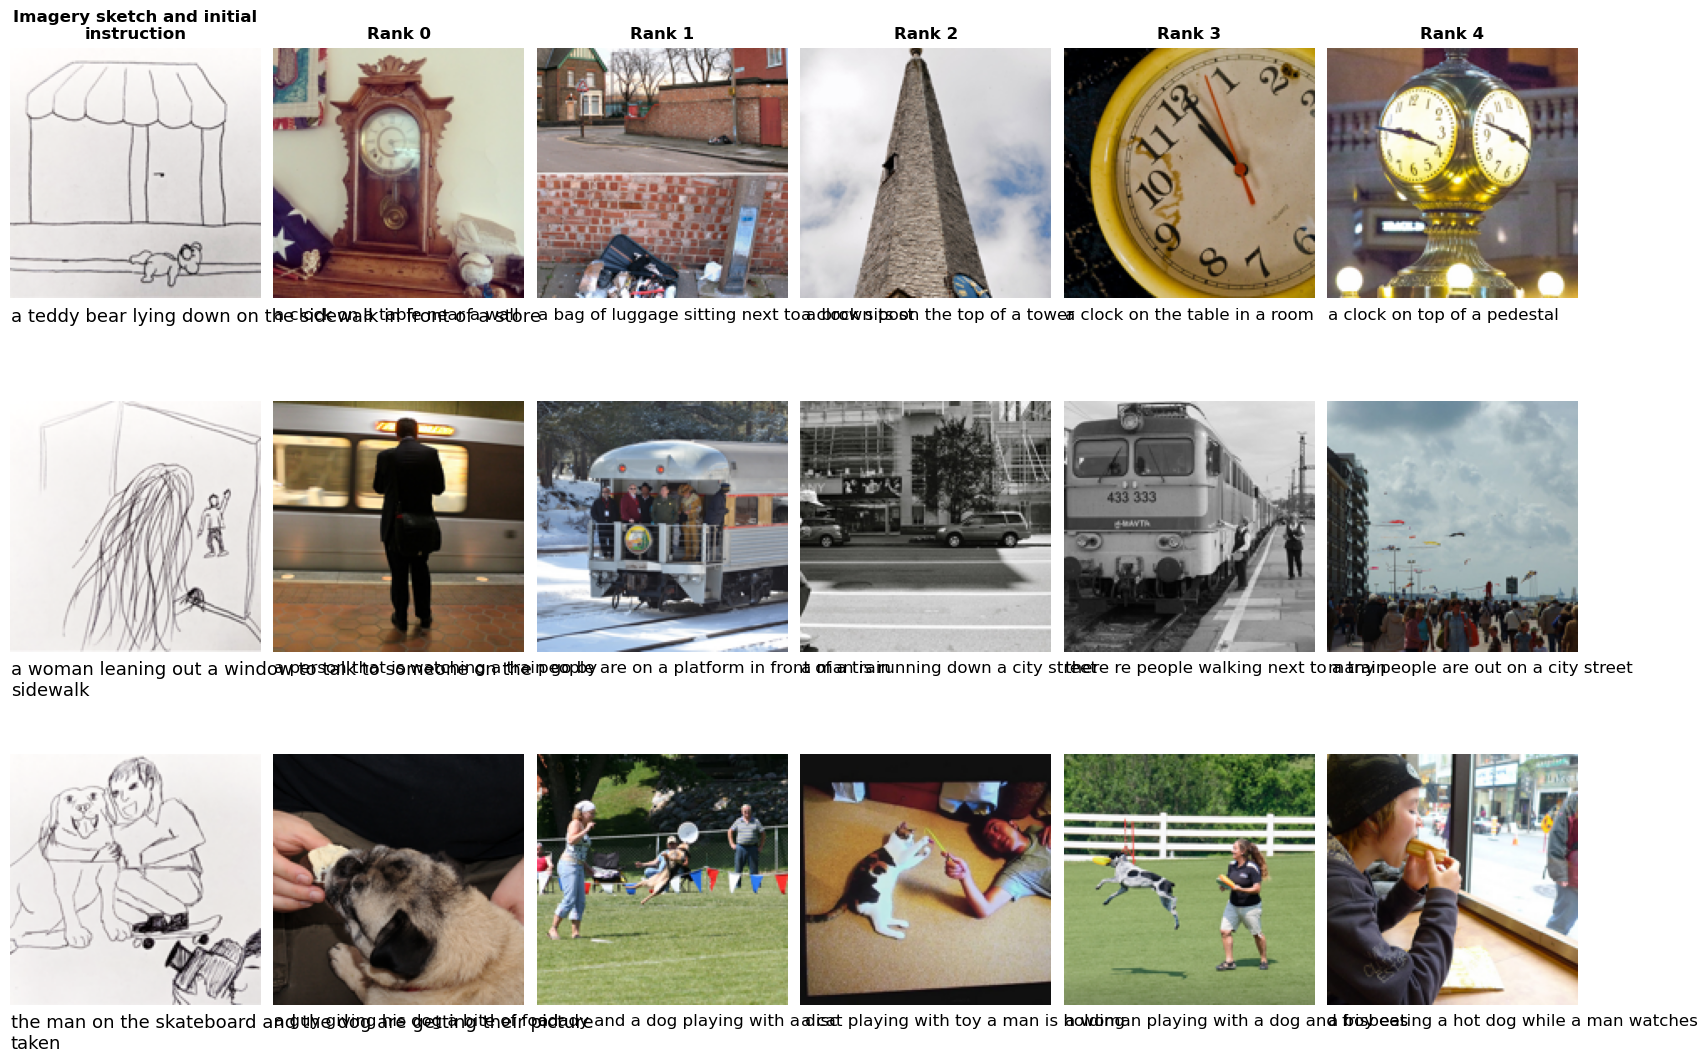

In [8]:
N_NEIGHBORS = 5
N_SAMPLES = 3

WHOLE_TRAIN_AND_TEST_SET_AS_CANDIDATE_SET = True
SURFACE = True

MODEL = "imagebind"

# TRAINING_MODE = "images"
# TRAINING_MODE = "captions"
TRAINING_MODE = "agnostic"

MASK = None

BETAS_SUFFIX = 'betas'

BETAS_DIR = os.path.join(FMRI_DATA_DIR, BETAS_SUFFIX)

RESTANDARDIZE_PREDS = True

FEATS = 'default'
TEST_FEATS = 'default'
VISION_FEATS = 'default'
LANG_FEATS = 'default'
FEATS_CONFIG = LatentFeatsConfig(MODEL, FEATS, TEST_FEATS, VISION_FEATS, LANG_FEATS)

all_pairwise_accs = []
for subj in SUBJECTS:
    print(subj)

    stim_ids, _ = get_stim_info(subj, SPLIT_TRAIN)
    
    train_latents = get_latent_features(FEATS_CONFIG, subj, SPLIT_TRAIN)
    test_latents = get_latent_features(FEATS_CONFIG, subj, SPLIT_TEST)
    imagery_latents = get_latent_features(FEATS_CONFIG, subj, SPLIT_IMAGERY)
    
    train_latents, test_latents, imagery_latents = standardize_latents(
        train_latents, test_latents, imagery_latents
    )

    results = load_results(BETAS_DIR, subj, TRAINING_MODE, FEATS_CONFIG, surface=SURFACE, mask=MASK)
        
    pred_latents_imagery = results['imagery_predictions']
    if RESTANDARDIZE_PREDS:
        print('standardizing imagery predictions')
        # pred_latents = results['predictions']
        # transform = StandardScaler().fit(pred_latents)
        # pred_latents_imagery = transform.transform(pred_latents_imagery)
        pred_latents_imagery = StandardScaler().fit_transform(pred_latents_imagery)

    test_stim_ids_mod = results['stimulus_ids'][results['stimulus_types'] == IMAGE]
    test_latents_mod = results['latents'][results['stimulus_types'] == IMAGE]

    if WHOLE_TRAIN_AND_TEST_SET_AS_CANDIDATE_SET:
        # # account for case that sometimes both the image and the caption are part of the training set
        # unique_stim_ids, indices = np.unique(stim_ids, return_index=True)
        # unique_train_latents = train_latents[indices]
        unique_stim_ids, indices = np.unique(all_train_stim_ids, return_index=True)
        unique_train_latents = all_train_latents[indices]
        print('candidate set size: ', len(unique_stim_ids))
        
        candidate_latents = np.concatenate((results['imagery_latents'], test_latents_mod, unique_train_latents))
        candidate_latent_ids = np.concatenate((results['imagery_stimulus_ids'], test_stim_ids_mod, unique_stim_ids))
    else:
        candidate_latents = results['imagery_latents']
        candidate_latent_ids = results['imagery_stimulus_ids']

    acc = analysis_ranking(pred_latents_imagery, results['imagery_stimulus_ids'], candidate_latents, candidate_latent_ids, subj, IMAGERY, N_SAMPLES, N_NEIGHBORS, out_file_name=f"{IMAGERY}_{TRAINING_MODE}_decoder_{subj}.png", hspace=0.2)
    all_pairwise_accs.append(acc)

print(f'Mean pairwise acc: {np.mean(all_pairwise_accs):.2f}')

# TSNE for Latents

In [ ]:
# train_fmri_betas_full, train_stim_ids, train_stim_types = get_fmri_data(
#     BETAS_DIR,
#     SUBJECT,
#     SPLIT_TRAIN,
#     TRAINING_MODE,
#     surface=SURFACE,
# )
# N_TRAIN_BETAS = 1000
# train_paths = train_paths[np.random.choice(range(len(train_paths)), size=N_TRAIN_BETAS, replace=False)]

# train_fmri_betas, test_fmri_betas, train_fmri_betas_standardized, test_fmri_betas_standardized = load_betas(train_paths, test_paths)

In [ ]:
# def plot_betas(train_betas, test_betas, title, binwidth=3):
#     X = np.concatenate((train_betas.flatten(), test_betas.flatten()))
#     hue = ['train'] * train_betas.size + ['test'] * test_betas.size
#     plt.figure(figsize=(20, 10))
#     sns.histplot(x=X, hue=hue, binwidth=binwidth)
#     plt.title(title)

# print(np.nanmean(train_fmri_betas.mean(axis=0)))
# print(np.nanmean(test_fmri_betas.mean(axis=0)))
# print(np.nanmean(train_fmri_betas_standardized.mean(axis=0)))
# print(np.nanmean(test_fmri_betas_standardized.mean(axis=0)))

# plot_betas(train_fmri_betas, test_fmri_betas, title='unstandardized')
# plt.ylim(0, 10000000)
# plt.xlim(-25, 25)

# plot_betas(train_fmri_betas_standardized, test_fmri_betas, title='standardized', binwidth=0.3)
# plt.ylim(0, 4000000)
# plt.xlim(-3, 3)

In [ ]:
# SUBJECT = 'sub-01'
# MODEL = "imagebind"
# SURFACE = True

# # TRAINING_MODE = "images"
# TRAINING_MODE = "agnostic"

# BETAS_SUFFIX = 'betas'
# BETAS_DIR = os.path.join(FMRI_DATA_DIR, BETAS_SUFFIX)

# # feats = 'avg'
# # test_feats = 'avg'
# FEATS = 'default'
# TEST_FEATS = 'default'
# # feats = 'lang'
# # test_feats = 'lang'
# # vision_feats = 'vision_features_cls'
# VISION_FEATS = 'default'
# # vision_feats = 'n_a'

# LANG_FEATS = 'default'
# # lang_feats = 'lang_features_cls'
# # lang_feats = 'lang_features_mean'

# FEATS_CONFIG = LatentFeatsConfig(MODEL, FEATS, TEST_FEATS, VISION_FEATS, LANG_FEATS)


# test_fmri_betas, test_stim_ids, test_stim_types = get_fmri_data(
#     BETAS_DIR,
#     SUBJECT,
#     SPLIT_TEST,
#     surface=SURFACE,
# )
# imagery_fmri_betas, imagery_stim_ids, imagery_stim_types = get_fmri_data(
#     BETAS_DIR,
#     SUBJECT,
#     SPLIT_IMAGERY,
#     surface=SURFACE,
# )

# train_latents = get_latent_features(FEATS_CONFIG, SUBJECT, SPLIT_TRAIN, mode=TRAINING_MODE)
# test_latents = get_latent_features(FEATS_CONFIG, SUBJECT, SPLIT_TEST)
# imagery_latents = get_latent_features(FEATS_CONFIG, SUBJECT, SPLIT_IMAGERY)

# train_latents, test_latents, imagery_latents = standardize_latents(
#     train_latents, test_latents, imagery_latents
# )

# results = load_results(BETAS_DIR, SUBJECT, TRAINING_MODE, FEATS_CONFIG, surface=SURFACE)

# # stim_ids, stim_types, train_latents, gray_matter_mask, results, train_paths, test_paths = load(BETAS_DIR, MODEL, SUBJECT, MODE, FEATS_CONFIG)


In [ ]:
# def plot_latents_tsne(train_lat, test_lat, pred_lat, imagery_pred_lat, title, train_subset=1000):
#     train_latents_subset = train_latents[np.random.choice(range(len(train_lat)), size=train_subset, replace=False)]
    
#     tsne = TSNE(n_components=2, learning_rate='auto', verbose=1, n_jobs=10, n_iter=1000)
#     X_embedded = tsne.fit_transform(np.concatenate((train_latents_subset, test_lat, pred_lat, imagery_pred_lat)))
    
#     print(X_embedded.shape)
#     assert X_embedded.shape[1] == 2
#     hue = ['train'] * len(train_latents_subset) + ['test'] * len(test_lat) + ['predictions'] * len(pred_lat) + ['imagery_predictions'] * len(imagery_pred_lat)
#     # alphas = [0.3] * len(train_latents_subset) + [1] * len(test_lat) + [1] * len(preds)
    
#     plt.figure(figsize=(20, 12))
#     sns.scatterplot(
#         x = X_embedded[:, 0], y = X_embedded[:, 1],
#         hue = hue,
#         alpha = 0.8
#     )
#     plt.title(title)

# plot_latents_tsne(train_latents, results['latents'], results['predictions'], results['imagery_predictions'], title="not standardized")

# pred_latents_standardized = StandardScaler().fit_transform(results['predictions'])   
# imagery_pred_latents_standardized = StandardScaler().fit_transform(results['imagery_predictions'])
# plot_latents_tsne(train_latents, results['latents'], pred_latents_standardized, imagery_pred_latents_standardized, "standardized")

# TSNE for Betas

In [ ]:
# def plot_betas_tsne(train_betas, test_betas, title, train_subset=None):
#     if train_subset is not None:
#         train_betas_subset = train_betas[np.random.choice(range(len(train_betas)), size=train_subset, replace=False)]
#     else:
#         train_betas_subset = train_betas
#     train_test = np.concatenate((train_betas_subset, test_betas))
#     tsne = TSNE(n_components=2, learning_rate='auto', verbose=1, n_jobs=10, n_iter=1000)
#     X_embedded = tsne.fit_transform(train_test)
    
#     print(X_embedded.shape)
#     assert X_embedded.shape[1] == 2
#     hue = ['train'] * len(train_betas_subset) + ['test'] * len(test_betas)
#     # alpha = [1] * len(test_betas) + [0.3] * len(train_betas_subset)
    
#     plt.figure(figsize=(20, 12))
#     sns.scatterplot(
#         x = X_embedded[:, 0], y = X_embedded[:, 1],
#         hue = hue,
#         # alpha = alpha
#     )
#     plt.title(title)

# plot_betas_tsne(train_fmri_betas, test_fmri_betas, title="not standardized")
# plot_betas_tsne(train_fmri_betas_standardized, test_fmri_betas_standardized, "standardized")
